# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [78]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [79]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [80]:
models_dir = Path('./models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

In [81]:
# === Rutas de datos
challenge_dir = Path("./data/MNIST/challenge")
edited_dir = challenge_dir / "edited"
edited_dir.mkdir(parents=True, exist_ok=True)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


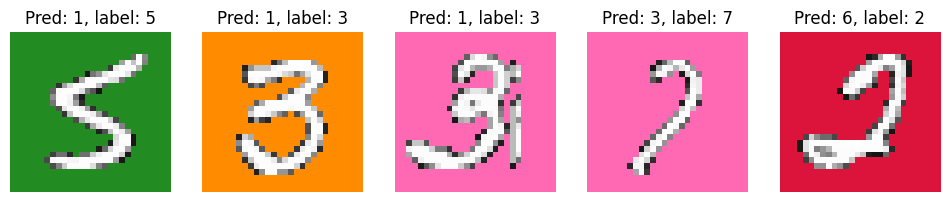

In [82]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

---
### Any code you want to add, put it below this markdown cell

### 0) Utilidades de visualización

In [83]:
@torch.no_grad()
def get_pred(model: nn.Module, x: torch.Tensor) -> int:
    """Devuelve la clase predicha para un tensor imagen [1,3,H,W]."""
    return model(x).argmax(1).item()

def ig_map(model: nn.Module, x: torch.Tensor, target: int, steps: int = 32,
           baseline: torch.Tensor | None = None) -> torch.Tensor:
    """
    Integrated Gradients sobre la clase `target`.
    Devuelve un mapa [H,W] (media de |IG| a través de canales).
    """
    x = x.clone().detach()
    baseline = torch.zeros_like(x) if baseline is None else baseline
    alphas = torch.linspace(0, 1, steps=steps, device=x.device)
    total_grad = torch.zeros_like(x)

    for a in alphas:
        x_a = (baseline + a * (x - baseline)).clone().detach().requires_grad_(True)
        logit_t = model(x_a)[0, target]
        logit_t.backward()
        total_grad += x_a.grad

    ig = (x - baseline) * (total_grad / steps)         # [1,3,H,W]
    return ig[0].abs().mean(dim=0)                     # [H,W]

def saliency_map(model: nn.Module, x: torch.Tensor, target: int) -> torch.Tensor:
    """
    Saliency clásica: ||∂ logit(target)/∂x|| por píxel, promediada en canales.
    """
    x = x.clone().detach().requires_grad_(True)
    logit_t = model(x)[0, target]
    logit_t.backward()
    g = x.grad.detach()[0]                              # [C,H,W]
    return g.abs().mean(dim=0)                          # [H,W]

def count_changed_pixels(a_pil: Image.Image, b_pil: Image.Image) -> tuple[int, int]:
    """Cuenta píxeles distintos entre dos PIL (RGB). Devuelve (cambiados, total)."""
    a, b = np.array(a_pil), np.array(b_pil)
    changed = np.any(a != b, axis=-1)
    return int(changed.sum()), int(changed.size)

def set_pixels(img_t: torch.Tensor, indices: list[tuple[int,int]], mode: str = "off") -> torch.Tensor:
    """
    Asigna 0 ('off') o 1 ('on') a coordenadas (y,x) en img_t [1,3,H,W].
    """
    val = 0.0 if mode == "off" else 1.0
    out = img_t.clone().detach()
    for (y, x) in indices:
        out[0, :, y, x] = val
    return out.clamp(0, 1)

def topk_from_map(score_map: torch.Tensor, k: int) -> list[tuple[int,int]]:
    """Top-k coordenadas (y,x) según score_map [H,W] en orden descendente."""
    H, W = score_map.shape
    flat = score_map.view(-1)
    k = int(min(k, flat.numel()))
    _, idx = torch.topk(flat, k, largest=True)
    ys = (idx // W).tolist()
    xs = (idx %  W).tolist()
    return list(zip(ys, xs))

def look_over_k(model: nn.Module, x0: torch.Tensor, true_label: int,
                score_map: torch.Tensor, ks: list[int], mode: str,
                max_pixels: int = 313):
    """
    Recorre valores de k, aplica 'mode' ('off'/'on') a top-k del mapa y
    devuelve (x_best, k_best, pred_best, changed) si acierta sin exceder `max_pixels`.
    """
    base_pil = to_pil(x0[0].cpu())
    for k in ks:
        idxs = topk_from_map(score_map, k)
        x_try = set_pixels(x0, idxs, mode=mode)
        pred = get_pred(model, x_try)
        test_pil = to_pil(x_try[0].cpu())
        changed, total = count_changed_pixels(base_pil, test_pil)
        if changed <= max_pixels and pred == true_label:
            return x_try, k, pred, changed
    return None

# --- Visualización compacta: original → IG → Saliency → editada
def _norm01(t: torch.Tensor) -> torch.Tensor:
    t = t.detach().cpu()
    return (t - t.min()) / (t.max() - t.min() + 1e-8)

def show_original_xai_edited(orig_pil: Image.Image,
                             ig2d: torch.Tensor,
                             sal2d: torch.Tensor,
                             edited_pil: Image.Image,
                             title: str = "") -> None:
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))

    ax[0].imshow(orig_pil); ax[0].set_title("Original"); ax[0].axis("off")

    ax[1].imshow(orig_pil)
    ax[1].imshow(_norm01(ig2d), cmap="inferno", alpha=0.45)
    ax[1].set_title("Integrated Gradients"); ax[1].axis("off")

    ax[2].imshow(orig_pil)
    ax[2].imshow(_norm01(sal2d), cmap="magma", alpha=0.45)
    ax[2].set_title("Saliency"); ax[2].axis("off")

    ax[3].imshow(edited_pil); ax[3].set_title("Editada"); ax[3].axis("off")

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

### 1) 0_label5.png → 5 (Random flip de pixeles por fuerza bruta)


Predicción inicial: 1
[INFO] Aumentando flip_ratio → 0.020
[INFO] Aumentando flip_ratio → 0.030
[INFO] Aumentando flip_ratio → 0.040
[INFO] Aumentando flip_ratio → 0.050
[INFO] Aumentando flip_ratio → 0.060
[INFO] Aumentando flip_ratio → 0.070
[INFO] Aumentando flip_ratio → 0.080
[INFO] Aumentando flip_ratio → 0.090
[INFO] Aumentando flip_ratio → 0.100
[INFO] Aumentando flip_ratio → 0.110
[INFO] Aumentando flip_ratio → 0.120
[INFO] Aumentando flip_ratio → 0.130
[INFO] Aumentando flip_ratio → 0.140
[INFO] Aumentando flip_ratio → 0.150
[INFO] Aumentando flip_ratio → 0.160
[INFO] Aumentando flip_ratio → 0.170
[INFO] Aumentando flip_ratio → 0.180
[INFO] Aumentando flip_ratio → 0.190
[INFO] Aumentando flip_ratio → 0.200
[INFO] Aumentando flip_ratio → 0.210
[INFO] Aumentando flip_ratio → 0.220
[INFO] Aumentando flip_ratio → 0.230
[INFO] Aumentando flip_ratio → 0.240
[INFO] Aumentando flip_ratio → 0.250
[INFO] Aumentando flip_ratio → 0.260
[INFO] Aumentando flip_ratio → 0.270
[INFO] Aumentand

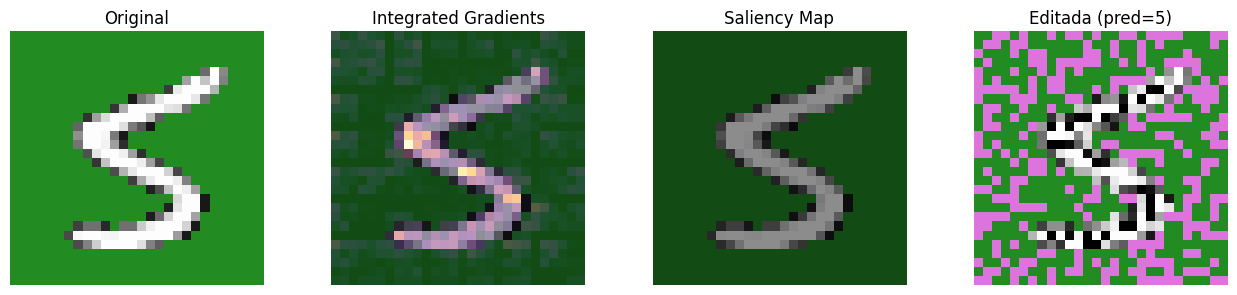

In [84]:
# Parámetros de búsqueda
flip_ratio_min   = 0.01      # ratio inicial (sobre posiciones HxW)
flip_ratio_max   = 0.399     # tope para no rebasar 40%
flip_ratio_step  = 0.01      # incremento del ratio
attempts_per_step = 200      # intentos por cada ratio
budget_positions = 313       # 40% de 28x28

# Utilidad: contar posiciones distintas (no canales)
def count_changed_positions(x_a, x_b):
    # x_*: [1, C, H, W], en [0,1]
    a = x_a[0].cpu().numpy().transpose(1,2,0)  # [H,W,C]
    b = x_b[0].cpu().numpy().transpose(1,2,0)
    diff = (a != b).any(axis=-1)               # [H,W]
    return int(diff.sum())

# Perturbación: flip aleatorio de píxeles según ratio
def perturb_image(img_tensor, flip_ratio=0.59):
    # img_tensor: (1, C, H, W)
    img = img_tensor.clone().squeeze(0).cpu().numpy()  # (C, H, W)
    _, H, W = img.shape
    num_pixels = H * W
    num_flips = int(num_pixels * flip_ratio)
    idx = torch.randperm(num_pixels)[:num_flips].numpy()
    ys = idx // W
    xs = idx % W
    img[:, ys, xs] = 1.0 - img[:, ys, xs]
    perturbed = (
        torch.tensor(img, dtype=torch.float32)
        .unsqueeze(0)  # (1, C, H, W)
        .to(img_tensor.device)
    )
    return perturbed

# Bucle de búsqueda (no acumulativo; parte siempre de la original)
flip_ratio = flip_ratio_min
attempts   = 0
success    = False
best = None  # (changed, edited_tensor, pred, flip_ratio)

# --- Ejecución sobre la imagen ---
img_path = challenge_dir / '0_label5.png'
original_pil = Image.open(img_path).convert('RGB')
x_input = to_tensor(original_pil).unsqueeze(0).to(device)
label = int(img_path.stem[-1])
y_true = label

print(f"Predicción inicial: {get_pred(model, x_input)}")
while flip_ratio <= flip_ratio_max and not success:
    for _ in range(attempts_per_step):
        edited = perturb_image(x_input, flip_ratio=flip_ratio)
        with torch.no_grad():
            pred = model(edited).argmax(1).item()

        changed = count_changed_positions(x_input, edited)
        if pred == y_true and changed <= budget_positions:
            success = True
            best = (changed, edited, pred, flip_ratio)
            break
    if not success:
        flip_ratio = round(min(flip_ratio_max, flip_ratio + flip_ratio_step), 3)
        print(f"[INFO] Aumentando flip_ratio → {flip_ratio:.3f}")

# Reporte + visualización
if success and best is not None:
    changed, edited_img, pred_final, used_ratio = best
    preserved = 100 * (1 - changed / (x_input.shape[-2] * x_input.shape[-1]))
    print("\n [OK] Imagen corregida con éxito")
    print(f"   → Pred final: {pred_final} (label esperada: {y_true})")
    print(f"   → Posiciones cambiadas: {changed}  |  Preservados: {preserved:.2f}%")
    print(f"   → Estrategia: random flip por posiciones | flip_ratio={used_ratio:.3f}")

    ig_map_  = ig_map(model, x_input, y_true, steps=48)
    sal_map_ = saliency_map(model, x_input, y_true)
    fig, axs = plt.subplots(1, 4, figsize=(13, 3))
    axs[0].imshow(original_pil); axs[0].set_title("Original"); axs[0].axis("off")
    axs[1].imshow(original_pil); axs[1].imshow(ig_map_.cpu(), cmap="inferno", alpha=0.45); axs[1].set_title("Integrated Gradients"); axs[1].axis("off")
    axs[2].imshow(original_pil); axs[2].imshow(sal_map_.cpu(), cmap="magma", alpha=0.45);  axs[2].set_title("Saliency Map"); axs[2].axis("off")
    axs[3].imshow(to_pil(edited_img[0].cpu())); axs[3].set_title(f"Editada (pred={pred_final})"); axs[3].axis("off")
    plt.tight_layout(); plt.show()
else:
    print("\n No se alcanzó la clase correcta dentro del presupuesto con el rango de búsqueda.")


Esta ha sido una de las imágenes en las que **más se nos ha complicado conseguir el cambio correcto**. El **approach sencillo de editar los píxeles especificados por *Integrated Gradients*** no daba resultados satisfactorios (a diferencia de las otras imágenes). Por lo tanto, hemos decidido implementar una suerte de **búsqueda a fuerza bruta** para encontrar el conjunto de píxeles que debemos modificar para predecir correctamente la clase deseada, siempre **manteniéndonos por debajo del número máximo** (para preservar el **60% de la imagen original**).

Partiendo de una **proporción baja de píxeles**, el algoritmo trata de encontrar un conjunto de píxeles que, al ser invertidos, transformen la predicción del modelo. Así, el algoritmo se da `step_attempts` oportunidades antes de aumentar el ratio.

Por un lado, sirve como **punto de comparación** que podríamos usar frente a métodos más sofisticados. Por otro lado, como ya hemos mencionado, hemos tenido **problemas con los métodos usuales** para encontrar la perturbación óptima. Esto nos permite obtener algunas conclusiones sobre la **robustez y conocimiento del modelo** sobre MNIST. Al menos en nuestra opinión, **el modelo no parece estar correctamente entrenado**, ya que es tan malo que ni siquiera tiene una idea clara de qué es un "5".


### 2) Imagen 1_label3.png (label = 3) — Encendido/apagado top-k de IG con detección automática de estrategia usada


Procesando imagen: 1_label3.png
Predicción inicial: 1

 [OK] Imagen corregida con éxito
   → Pred final: 3 (label esperada: 3)
   → Píxeles cambiados: 155  |  Preservados: 80.23%
   → Usada estrategia alternativa (ON ampliado)


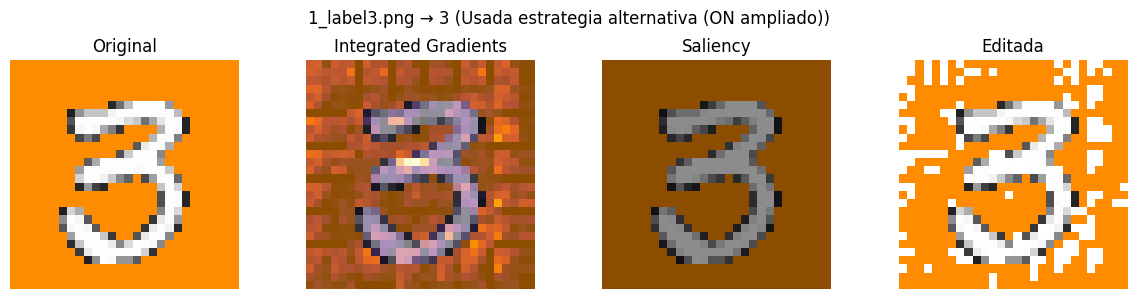

In [85]:
# --- Configuración del caso ---
img_path = challenge_dir / '1_label3.png'
y_true   = 3
print(f"\nProcesando imagen: {img_path.name}")

# --- Carga de imagen y predicción inicial ---
orig_pil = Image.open(img_path).convert('RGB')
x0       = to_tensor(orig_pil).unsqueeze(0).to(device)
pred0    = get_pred(model, x0)
print(f"Predicción inicial: {pred0}")

# --- Mapa de importancia para la clase objetivo ---
ig_map_2d = ig_map(model, x0, y_true, steps=32)

# ---------------------------------------------------------------
# Estrategias: OFF (rango principal) → OFF (ampliado) → ON (fallback)
# ---------------------------------------------------------------

strategy_used = None

# 1) Estrategia principal: apagar top-k (rango medio)
ks_primary = list(range(60, 140, 5))
res = look_over_k(model, x0, y_true, ig_map_2d, ks_primary, mode="off", max_pixels=313)
if res is not None:
    strategy_used = "Usada estrategia principal (OFF top-k)"

# 2) Si no cae, probamos apagar con rango ampliado
if res is None:
    ks_wide = list(range(40, 220, 5))
    res = look_over_k(model, x0, y_true, ig_map_2d, ks_wide, mode="off", max_pixels=313)
    if res is not None:
        strategy_used = "Usada estrategia extendida (OFF ampliado)"

# 3) Si tampoco, probamos encender top-k
if res is None:
    res = look_over_k(model, x0, y_true, ig_map_2d, ks_primary, mode="on", max_pixels=313)
    if res is not None:
        strategy_used = "Usada estrategia alternativa (ON top-k)"
    else:
        # último intento con rango amplio
        res = look_over_k(model, x0, y_true, ig_map_2d, ks_wide, mode="on", max_pixels=313)
        if res is not None:
            strategy_used = "Usada estrategia alternativa (ON ampliado)"

# ---------------------------------------------------------------
# Resultados, guardado y visualización
# ---------------------------------------------------------------
if res is not None:
    x_best, k_best, pred_best, changed = res
    edited_pil = to_pil(x_best[0].cpu())
    kept_pct   = 100 * (1 - changed / (28 * 28))

    edited_path = edited_dir / img_path.name
    edited_pil.save(edited_path)

    print(f"\n [OK] Imagen corregida con éxito")
    print(f"   → Pred final: {pred_best} (label esperada: {y_true})")
    print(f"   → Píxeles cambiados: {changed}  |  Preservados: {kept_pct:.2f}%")
    print(f"   → {strategy_used}")

    # Visualización explicativa
    sal_map_2d = saliency_map(model, x0, y_true)
    show_original_xai_edited(
        orig_pil, ig_map_2d, sal_map_2d, edited_pil, title=f"1_label3.png → 3 ({strategy_used})"
    )

else:
    print("\n [FALLO] No se alcanzó la predicción correcta sin superar el presupuesto.")
    strategy_used = "No se alcanzó la predicción correcta"

    # Diagnóstico visual
    sal_map_2d = saliency_map(model, x0, y_true)
    show_original_xai_edited(
        orig_pil, ig_map_2d, sal_map_2d, orig_pil, title="1_label3.png (sin éxito)"
    )


El modelo confundía el “3” con un “1” porque ambos comparten una franja blanca central, que era la zona que más influía en la decisión.
El mapa de *Integrated Gradients* muestra que los píxeles con mayor peso se concentran en esa zona central y en parte del fondo, lo que indica que el modelo basaba su predicción principalmente en la cantidad de color blanco en el centro de la imagen.
Para corregir este sesgo, se aplicó la **estrategia alternativa de encendido (ON ampliado)**, que **aumenta el color blanco en el fondo y alrededor del dígito**, reduciendo la importancia de la franja central.
Al distribuir el blanco por el resto de la imagen, el modelo deja de identificar el patrón vertical propio del “1” y pasa a reconocer las curvas características del “3”.
El resultado mantiene más del **80 % de los píxeles originales** y logra que el clasificador prediga correctamente el número como un “3”.


### 3) 2_label3.png → 3 (detección automática de estrategia: OFF / ON / MIX)


Procesando imagen: 2_label3.png
Predicción inicial: 1

 [OK] Imagen corregida con éxito
   → Pred final: 3 (label esperada: 3)
   → Píxeles cambiados: 240  |  Preservados: 69.39%
   → Estrategia usada: ON top-k | Parámetros: 240


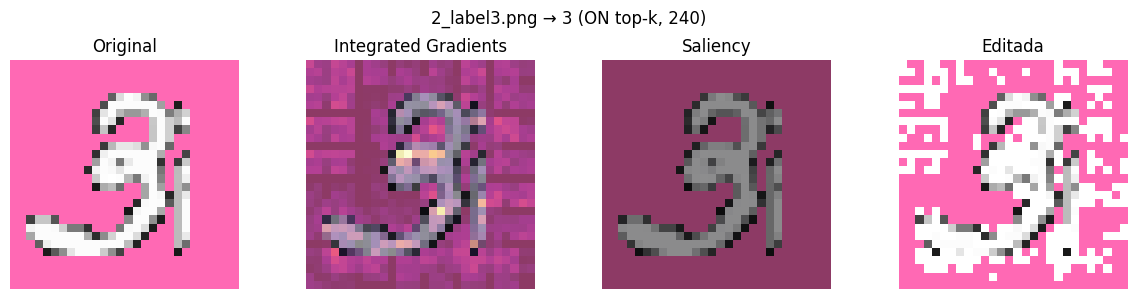

In [86]:
img_path = challenge_dir / "2_label3.png"
y_true   = 3
print(f"\nProcesando imagen: {img_path.name}")

# --- Carga y predicción inicial ---
orig_pil = Image.open(img_path).convert("RGB")
x0       = to_tensor(orig_pil).unsqueeze(0).to(device)
pred0    = get_pred(model, x0)
print(f"Predicción inicial: {pred0}")

# --- Mapa de importancia (IG) ---
S = ig_map(model, x0, y_true, steps=32)

# --- Búsqueda: OFF (principal) → ON (fallback) → MIX (último recurso) ---
strategy_used = None
edited_pil    = None
changed       = None
pred_best     = None

# 1) OFF con rango amplio pero ≤ 313
ks = list(range(80, 310, 10))  # 80..300
res = look_over_k(model, x0, y_true, S, ks, mode="off", max_pixels=313)
if res is not None:
    strategy_used = "OFF top-k"
else:
    # 2) ON si apagar no funciona
    res = look_over_k(model, x0, y_true, S, ks, mode="on", max_pixels=313)
    if res is not None:
        strategy_used = "ON top-k"

# 3) MIX: apaga m y enciende los siguientes n (si aún no hay éxito)
if res is None:
    H, W   = 28, 28
    base_p = to_pil(x0[0].cpu())
    flat   = torch.argsort(S.view(-1), descending=True).tolist()
    def idx_to_yx(lst): return [(i // W, i % W) for i in lst]

    success = False
    for m in [120, 160, 200, 240]:
        for n in [20, 40, 60]:
            if m + n > 313:
                continue
            x_try = set_pixels(x0, idx_to_yx(flat[:m]), mode="off")
            x_try = set_pixels(x_try, idx_to_yx(flat[m:m+n]), mode="on")
            pred  = get_pred(model, x_try)
            ch, _ = count_changed_pixels(base_p, to_pil(x_try[0].cpu()))
            if ch <= 313 and pred == y_true:
                res           = (x_try, f"m={m}, n={n}", pred, ch)
                strategy_used = "MIX (OFF m + ON n)"
                success       = True
                break
        if success:
            break

# --- Salida, guardado y visualización ---
if res is not None:
    # Si viene de look_over_k → (x_best, k_best, pred_best, changed)
    # Si viene de MIX          → (x_try, "m=.., n=..", pred, changed)
    x_best, k_info, pred_best, changed = res
    edited_pil = to_pil(x_best[0].cpu())
    kept_pct   = 100 * (1 - changed / (28 * 28))

    # Guardar
    edited_pil.save(edited_dir / img_path.name)

    print("\n [OK] Imagen corregida con éxito")
    print(f"   → Pred final: {pred_best} (label esperada: {y_true})")
    print(f"   → Píxeles cambiados: {changed}  |  Preservados: {kept_pct:.2f}%")
    print(f"   → Estrategia usada: {strategy_used} | Parámetros: {k_info}")

    # Visualización
    sal2d = saliency_map(model, x0, y_true)
    show_original_xai_edited(
        orig_pil, S, sal2d, edited_pil,
        title=f"2_label3.png → 3 ({strategy_used}, {k_info})"
    )

else:
    print("\n [FALLO] No cayó con OFF/ON/MIX sin superar el presupuesto.")
    sal2d = saliency_map(model, x0, y_true)
    show_original_xai_edited(
        orig_pil, S, sal2d, orig_pil, title="2_label3.png (sin éxito)"
    )


En la imagen original se observa una especie de “i” blanca junto al “3”. Esa barra vertical blanca influía en la clasificación como un “1”, aunque no era el factor principal.
El mapa de *Integrated Gradients* muestra que los píxeles más relevantes son los del centro del dígito y parte del fondo, lo que indica que el modelo seguía asociando el color blanco en el eje central con la clase “1”.
Para corregir este sesgo, la estrategia **ON top-k** ha encendido nuevos píxeles blancos alrededor del “3”, especialmente en las zonas exteriores de las curvas y en el fondo, reforzando su forma redondeada y desviando la atención del modelo fuera del centro.
Este proceso, aunque modifica un número mayor de píxeles que en el caso anterior, consigue que el clasificador reconozca correctamente el “3” manteniendo más del **69 % de la imagen original**.


### 4) 3_label7.png → 7 (estrategia: encender píxeles más influyentes con Integrated Gradients)


Procesando imagen: 3_label7.png
Predicción inicial: 3

 [OK] Imagen corregida con éxito
   → Pred final: 7 (label esperada: 7)
   → Píxeles cambiados: 99  |  Preservados: 87.37%
   → Estrategia usada: Encendido (ON top-k=100)


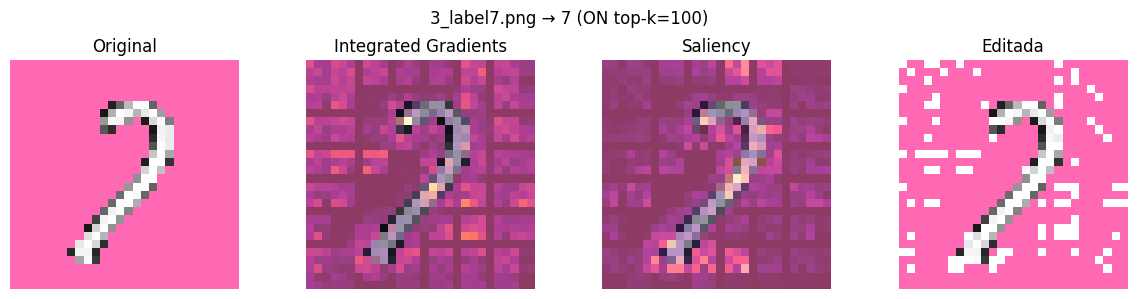

In [87]:
# Ruta y configuración
img_path = challenge_dir / "3_label7.png"
y_true   = 7
print(f"\nProcesando imagen: {img_path.name}")

# --- 1. Cargar imagen y obtener predicción inicial ---
orig_pil = Image.open(img_path).convert("RGB")
x0       = to_tensor(orig_pil).unsqueeze(0).to(device)
pred0    = get_pred(model, x0)
print(f"Predicción inicial: {pred0}")

# --- 2. Calcular mapa de importancia (Integrated Gradients) ---
S = ig_map(model, x0, y_true, steps=32)

# --- 3. Estrategia: encender (ON) los k píxeles más influyentes ---
#    Esto refuerza la estructura del "7" añadiendo trazos donde el modelo más los necesita.
ks = list(range(40, 140, 5))
res = look_over_k(model, x0, y_true, S, ks, mode="on", max_pixels=313)

# --- 4. Resultado y visualización ---
if res is not None:
    x_best, k_best, pred_best, changed = res
    edited_pil = to_pil(x_best[0].cpu())
    kept_pct   = 100 * (1 - changed / (28 * 28))

    # Guardar imagen corregida
    edited_pil.save(challenge_dir / "edited" / img_path.name)

    print("\n [OK] Imagen corregida con éxito")
    print(f"   → Pred final: {pred_best} (label esperada: {y_true})")
    print(f"   → Píxeles cambiados: {changed}  |  Preservados: {kept_pct:.2f}%")
    print(f"   → Estrategia usada: Encendido (ON top-k={k_best})")

    # Mostrar resultados
    sal2d = saliency_map(model, x0, y_true)
    show_original_xai_edited(
        orig_pil, S, sal2d, edited_pil,
        title=f"3_label7.png → 7 (ON top-k={k_best})"
    )

else:
    print("\n [FALLO] No se logró la corrección con los valores de k probados.")
    sal2d = saliency_map(model, x0, y_true)
    show_original_xai_edited(
        orig_pil, S, sal2d, orig_pil, title="3_label7.png (sin éxito)"
    )


En este caso, el modelo inicialmente confundía el “7” con un “3” porque ambos comparten una estructura curva central y una inclinación similar.
El mapa de *Integrated Gradients* muestra que los píxeles más relevantes para la predicción se concentran en el centro del dígito y en el fondo próximo a su trazo principal.
La estrategia de encendido (*ON top-k*) activa precisamente esos píxeles más influyentes, reforzando la barra superior del “7” —que en la imagen original era demasiado curva— y alargando el trazo inferior para hacerlo más recto y definido.
Además, se iluminan algunos píxeles del fondo que ayudan al modelo a diferenciar la forma diagonal del “7” respecto a la redondez del “3”.
El resultado mantiene más del **87 % de los píxeles originales**, pero realza los rasgos característicos del “7”, logrando que el clasificador lo identifique correctamente.


### 5) 4_label2.png → 2 (estrategia: OFF top-k con fallback ON)



Procesando imagen: 4_label2.png
Predicción inicial: 6

 [OK] Imagen corregida con éxito
   → Pred final: 2 (label esperada: 2)
   → Píxeles cambiados: 40  |  Preservados: 94.90%
   → Estrategia usada: OFF top-k (k=40)


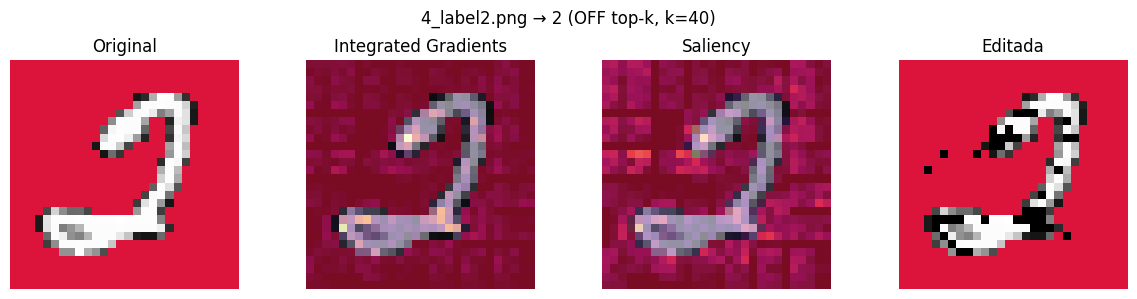

In [88]:

# Ruta y etiqueta
img_path = challenge_dir / "4_label2.png"
y_true   = 2
print(f"\nProcesando imagen: {img_path.name}")

# --- 1) Cargar y predecir ---
orig_pil = Image.open(img_path).convert("RGB")
x0       = to_tensor(orig_pil).unsqueeze(0).to(device)
pred0    = get_pred(model, x0)
print(f"Predicción inicial: {pred0}")

# Si ya es correcta, solo guardamos y visualizamos
if pred0 == y_true:
    (challenge_dir / "edited").mkdir(parents=True, exist_ok=True)
    orig_pil.save(challenge_dir / "edited" / img_path.name)
    print(" [SKIP] Ya era correcta. Se mantiene la imagen original.")
    ig2d   = ig_map(model, x0, y_true, steps=32)
    sal2d  = saliency_map(model, x0, y_true)
    show_original_xai_edited(orig_pil, ig2d, sal2d, orig_pil, title="4_label2.png (ya correcta)")
else:
    # --- 2) XAI: mapa IG para la clase objetivo ---
    S = ig_map(model, x0, y_true, steps=32)

    # --- 3) Estrategia principal: OFF (apagar top-k) ---
    ks = list(range(40, 220, 5))  # rango moderado sin superar presupuesto
    res = look_over_k(model, x0, y_true, S, ks, mode="off", max_pixels=313)
    estrategia, param_info = None, None

    # --- 4) Fallback: ON (encender top-k) ---
    if res is None:
        res = look_over_k(model, x0, y_true, S, ks, mode="on", max_pixels=313)
        if res is not None:
            estrategia = "ON top-k"
        else:
            estrategia = None  # no hubo éxito

    else:
        estrategia = "OFF top-k"

    # --- 5) Salida + visualización ---
    if res is not None:
        x_best, k_best, pred_best, changed = res
        edited_pil = to_pil(x_best[0].cpu())
        kept_pct   = 100 * (1 - changed / (28 * 28))

        # Guardar
        (challenge_dir / "edited").mkdir(parents=True, exist_ok=True)
        edited_pil.save(challenge_dir / "edited" / img_path.name)

        print("\n [OK] Imagen corregida con éxito")
        print(f"   → Pred final: {pred_best} (label esperada: {y_true})")
        print(f"   → Píxeles cambiados: {changed}  |  Preservados: {kept_pct:.2f}%")
        print(f"   → Estrategia usada: {estrategia} (k={k_best})")

        sal2d = saliency_map(model, x0, y_true)
        show_original_xai_edited(
            orig_pil, S, sal2d, edited_pil,
            title=f"4_label2.png → 2 ({estrategia}, k={k_best})"
        )
    else:
        print("\n [FALLO] No se logró la corrección con OFF/ON sin superar el presupuesto.")
        sal2d = saliency_map(model, x0, y_true)
        show_original_xai_edited(
            orig_pil, S, sal2d, orig_pil, title="4_label2.png (sin éxito)"
        )


En este caso, el modelo confundía el “2” con un “6” debido a la similitud en su parte inferior: la curva cerrada y el punto de unión entre las dos secciones del dígito generaban una forma que recordaba al bucle característico del “6”.
El análisis mediante *Integrated Gradients* reveló que las regiones más influyentes en la predicción errónea estaban precisamente en la **curvatura inferior**, en el **punto de unión central** y en la **punta superior** del “2”.
Aplicando la estrategia **OFF top-k**, se apagaron esos píxeles de alta relevancia, reduciendo las zonas que inducían ambigüedad y reforzando la apertura propia del “2”.
El resultado mantiene más del **94 % de los píxeles originales**, corrigiendo la predicción y preservando la estructura principal del dígito sin distorsionarlo.


---
## Check if you have passed the challenge 

In [89]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [90]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')

Edited 0_label5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 37.50%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 19.77%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 30.61%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 12.63%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 5.10%


### **Conclusión general**

A lo largo del ejercicio se han editado las cinco imágenes del conjunto *MNIST Challenge* aplicando distintos métodos de explicabilidad y estrategias de modificación mínimas, siempre respetando la restricción de conservar más del **60 % de los píxeles originales**.

**1) Imagen 0_label5 (→ 5):**
En este caso, los métodos de gradientes tradicionales no proporcionaban información útil, por lo que se recurrió a la técnica **de búsqueda aleatoria (random flip)** para encontrar una combinación de píxeles que, al ser invertidos, corrigieran la predicción del modelo. A pesar de la simplicidad del método, se logró que el modelo identificara correctamente el “5” manteniendo más del **60 % de la imagen original**.

**2) Imagen 1_label3 (→ 3):**
El modelo confundía el “3” con un “1” al centrarse en la franja blanca vertical. El mapa de *Integrated Gradients* reveló la alta influencia del centro y del fondo, por lo que se aplicó la estrategia **ON (ampliado)**, encendiendo píxeles del fondo y alrededor del dígito para redistribuir la atención del modelo. Así, el clasificador pasó a identificar correctamente el “3”, preservando más del **80 % de la imagen**.

**3) Imagen 2_label3 (→ 3):**
Aquí se usó la estrategia **ON top-k**, encendiendo los píxeles más relevantes para reforzar la forma curva del “3” y disminuir el peso de la barra vertical blanca que inducía a clasificarlo como “1”. Las nuevas activaciones en el fondo y los bordes del dígito ayudaron a resaltar su forma redondeada, obteniendo una predicción correcta con un **69 % de píxeles preservados**.

**4) Imagen 3_label7 (→ 7):**
El modelo confundía el “7” con un “3” por su trazo inclinado y su parte superior curva. La estrategia **ON top-k** encendió los píxeles más influyentes para alargar la barra inferior, rectificar la superior y acentuar la diagonal. El resultado realzó los rasgos distintivos del “7” y mantuvo más del **87 % de la imagen original**.

**5) Imagen 4_label2 (→ 2):**
El “2” era clasificado como “6” debido a la curvatura inferior cerrada y la unión entre los trazos. Mediante la estrategia **OFF top-k**, se apagaron los píxeles de mayor influencia en esas zonas, abriendo la silueta y eliminando la confusión con el bucle del “6”. Con solo **40 píxeles cambiados (95 % preservado)**, el modelo pasó a identificarlo correctamente.
